In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn import metrics

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

#Import libraries for decision tree creation
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus

from sklearn.naive_bayes import GaussianNB

from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import mean_absolute_error

In [2]:
#Loading the dataset into a DataFrame

data = pd.read_csv("600092_data.csv")
data.head()

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,0.602437,218242,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,0.602437,159284,TIA,no,no,no,no,no,70.0,60,NoRisk
2,0.602437,106066,A-F,no,yes,yes,no,no,95.0,40,Risk
3,0.128157,229592,TIA,no,no,yes,no,no,90.0,85,Risk
4,0.676862,245829,CVA,no,no,no,no,no,70.0,20,NoRisk


In [3]:
data.describe()

,Random,Id,IPSI
count,1520.000000,1520.000000,1516.000000
mean,0.509545,188365.022368,78.872032
std,0.284006,64355.870242,10.162351
min,0.000295,78261.000000,35.000000
25%,0.268531,137130.750000,73.000000
50%,0.517616,191344.500000,77.000000
75%,0.754724,244559.500000,85.000000
max,0.999448,295978.000000,99.000000


Running the describe function here shows there isn't many numeric columns in the dataset. What is interesting though is that the column Contra doesn't show up here, meaning that although it appears numeric in the dataframe above, it is actually an object, and needs to be converted.

In [4]:
#View the datatypes for each column of the dataframe
data.dtypes

Random          float64
Id                int64
Indication       object
Diabetes         object
IHD              object
Hypertension     object
Arrhythmia       object
History          object
IPSI            float64
Contra           object
label            object
dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
Random          1520 non-null float64
Id              1520 non-null int64
Indication      1517 non-null object
Diabetes        1518 non-null object
IHD             1520 non-null object
Hypertension    1517 non-null object
Arrhythmia      1520 non-null object
History         1518 non-null object
IPSI            1516 non-null float64
Contra          1520 non-null object
label           1517 non-null object
dtypes: float64(2), int64(1), object(8)
memory usage: 130.7+ KB


## Performing Initial Exploratory Data Analysis

The first step is to clean the data of any missing values. It depends on the amount of missing values, if these are small, there is a chance these can remain in, otherwise they will be removed.

We are mostly interested in the column 'Label', as this is where our main classification will take place, so lets start by checking how many Risk and No Risk values we have within this column.

In [6]:
#Create a new dataframe that only contains the values within the column label, and then count them
data["label"].value_counts()

NoRisk     1008
Risk        507
Unknown       2
Name: label, dtype: int64

Here we can see there are 2 Unknown values, alongside risk and no risk results.

In [7]:
#Show only the values with an unknown label value
label = data[data["label"] == "Unknown"]
label

,Random,Id,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
475,0.298074,173791,ASx,no,yes,yes,no,no,70.0,55,Unknown
523,0.460170,283846,CVA,no,no,yes,yes,no,95.0,100,Unknown


Lets replace those Unknown values with nan values that will be removed with any other null values

In [8]:
#Replace any values in the column label that equal Unknown into a NaN value
data["label"] = data["label"].replace("Unknown", np.nan)

In [9]:
#Check how many values exist
data.count()

Random          1520
Id              1520
Indication      1517
Diabetes        1518
IHD             1520
Hypertension    1517
Arrhythmia      1520
History         1518
IPSI            1516
Contra          1520
label           1515
dtype: int64

In [10]:
#Create a list that only includes the column data for Random and Id
del_col_list = ['Random', 'Id']

#Create a new dataframe without random and ID
clean_data = data.drop(del_col_list, axis=1)
clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
0,A-F,no,no,yes,no,no,78.0,20,NoRisk
1,TIA,no,no,no,no,no,70.0,60,NoRisk
2,A-F,no,yes,yes,no,no,95.0,40,Risk
3,TIA,no,no,yes,no,no,90.0,85,Risk
4,CVA,no,no,no,no,no,70.0,20,NoRisk


In [11]:
#Convert all values of the Contra column to numeric values
#any blank values found will be converted to NaN

clean_data["Contra"] = pd.to_numeric(clean_data["Contra"], errors="coerce")

In [12]:
#Finding all values that contain null values
null_data = clean_data[clean_data.isnull().any(axis=1)]
null_data

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label
201,CVA,yes,no,NaN,yes,no,95.0,90.0,Risk
337,CVA,no,yes,no,no,NaN,85.0,50.0,NoRisk
442,NaN,no,yes,yes,no,no,70.0,40.0,NoRisk
447,CVA,NaN,yes,yes,yes,no,90.0,100.0,Risk
453,ASx,no,no,yes,no,no,70.0,NaN,NoRisk
475,ASx,no,yes,yes,no,no,70.0,55.0,NaN
514,A-F,NaN,no,yes,no,no,80.0,40.0,NoRisk
523,CVA,no,no,yes,yes,no,95.0,100.0,NaN
590,A-F,no,no,NaN,no,no,78.0,30.0,NoRisk
620,A-F,no,no,no,no,no,NaN,100.0,Risk


It's important to first check how much of a percentage these records are before deciding if it is worthwhile to categorically fill them or simply remove them

In [13]:
#percentage of missing values in the dataset
null_data_percent = clean_data.isnull().sum() * 100 / len(clean_data)
null_data_percent

Indication      0.197368
Diabetes        0.131579
IHD             0.000000
Hypertension    0.197368
Arrhythmia      0.000000
History         0.131579
IPSI            0.263158
Contra          0.065789
label           0.328947
dtype: float64

This shows the percentage of values that are missing is fairly insignificant and will probably have no impact on the dataset, so they are safe to remove.

In [14]:
#Drop all data values that are null
clean_data = clean_data.dropna()
clean_data.isnull().sum()

Indication      0
Diabetes        0
IHD             0
Hypertension    0
Arrhythmia      0
History         0
IPSI            0
Contra          0
label           0
dtype: int64

The result shows there are no more null values present, and EDA can continue.

In [15]:
#Perform a new count to check how many values are present after removal
clean_data.count()

Indication      1500
Diabetes        1500
IHD             1500
Hypertension    1500
Arrhythmia      1500
History         1500
IPSI            1500
Contra          1500
label           1500
dtype: int64

In [16]:
clean_data.describe()

,IPSI,Contra
count,1500.000000,1500.000000
mean,78.828000,56.668000
std,10.159555,29.524977
min,35.000000,10.000000
25%,73.000000,30.000000
50%,77.000000,50.000000
75%,85.000000,85.000000
max,99.000000,100.000000


In [17]:
#Indication column has 4 expected values, lets check them
clean_data["Indication"].value_counts()

A-F    489
CVA    407
TIA    388
ASx    184
Asx     32
Name: Indication, dtype: int64

There are values present with ASx and Asx. Since the majority here are ASx, lets replace the other values so we are back to only 4 expected values, as per the Data Description document.

In [18]:
#Replace all values with Asx to ASx to match majority of values in the dataframe
clean_data["Indication"] = clean_data["Indication"].replace("Asx", "ASx")
clean_data["Indication"].value_counts()

A-F    489
CVA    407
TIA    388
ASx    216
Name: Indication, dtype: int64

In [19]:
#Run a check to make sure the label column only has risk and no risk
clean_data["label"].value_counts()

NoRisk    1000
Risk       500
Name: label, dtype: int64

As this point, the data has been cleaned.

In [20]:
#Create a dummy for the column label to better visualise risk vs no risk
clean_data_risk = pd.get_dummies(clean_data["label"])
#clean_data_indication = pd.get_dummies(clean_data["Indication"])

In [21]:
#Add the dummy variable we created to the end of our current table
clean_data = pd.concat([clean_data, clean_data_risk], axis=1)
#clean_data = pd.concat([clean_data, clean_data_indication],axis=1)
clean_data.head()

#Warning.. running this more than once will create duplicated dummy variables in the dataframe

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,no,no,yes,no,no,78.0,20.0,NoRisk,1,0
1,TIA,no,no,no,no,no,70.0,60.0,NoRisk,1,0
2,A-F,no,yes,yes,no,no,95.0,40.0,Risk,0,1
3,TIA,no,no,yes,no,no,90.0,85.0,Risk,0,1
4,CVA,no,no,no,no,no,70.0,20.0,NoRisk,1,0


This presents a small problem of duplication, for the time being a new table can be created which will not include the label column, but the original table will be kept

In [22]:
#Create a new variable for the label column
clean_data_label = ["label"]

#Create a new dataframe, and then drop the label column using the variable created above
clean_data_dummy = clean_data.drop(clean_data_label, axis=1)
clean_data_dummy.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,NoRisk,Risk
0,A-F,no,no,yes,no,no,78.0,20.0,1,0
1,TIA,no,no,no,no,no,70.0,60.0,1,0
2,A-F,no,yes,yes,no,no,95.0,40.0,0,1
3,TIA,no,no,yes,no,no,90.0,85.0,0,1
4,CVA,no,no,no,no,no,70.0,20.0,1,0


## Visualising the data

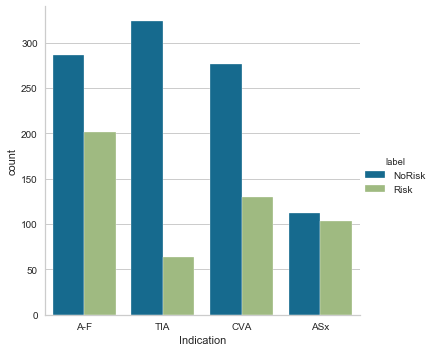

In [23]:
sns.set_style("whitegrid")
vis4 = sns.catplot(x="Indication", hue="label", data=clean_data, kind="count")

In [24]:
clean_data_dummy.groupby(["Indication", "Risk", "NoRisk"]).mean()

IPSI     Contra
Indication Risk NoRisk                      
A-F        0    1       76.452962  39.233449
           1    0       87.559406  81.267327
ASx        0    1       78.151786  35.705357
           1    0       82.788462  82.259615
CVA        0    1       74.877256  46.028881
           1    0       85.969231  88.038462
TIA        0    1       73.669753  46.595679
           1    0       85.375000  85.625000

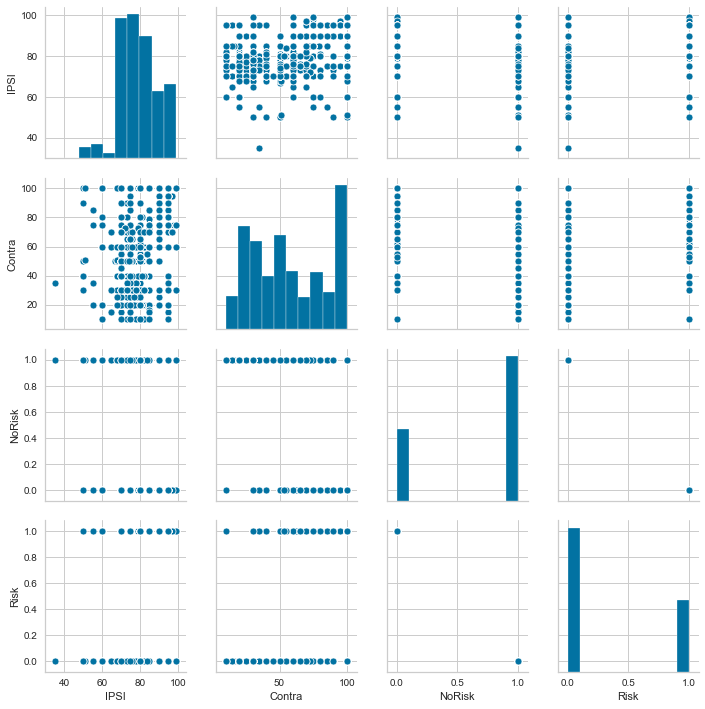

In [25]:
medical = clean_data_dummy
g = sns.pairplot(medical)

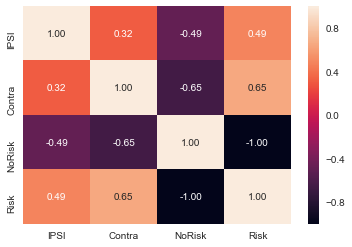

In [26]:
sns.heatmap(clean_data_dummy.corr(), annot=True, fmt=".2f")
plt.show()

In [27]:
#clean_data_with_dummies[clean_data_with_dummies["Indication"] == "A-F"] 

In [28]:
#dummies = pd.get_dummies(clean_data_dummy, columns= ["Diabetes", "IHD", "Hypertension",\
#                                                            "Arrhythmia","History"])
#dummies.head()

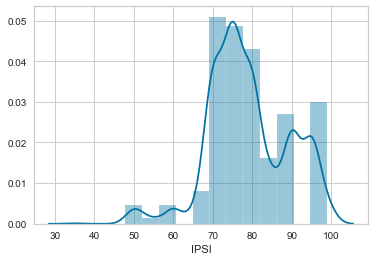

In [29]:
sns.distplot(clean_data["IPSI"], bins = 15)
plt.show()

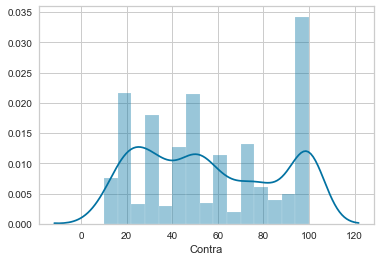

In [30]:
sns.distplot(clean_data["Contra"], bins = 15)
plt.show()

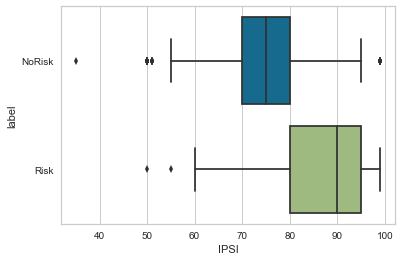

In [31]:
sns.boxplot(x = clean_data["IPSI"], y = clean_data["label"])

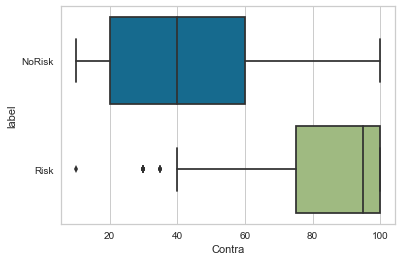

In [32]:
sns.boxplot(x = clean_data["Contra"], y = clean_data["label"])

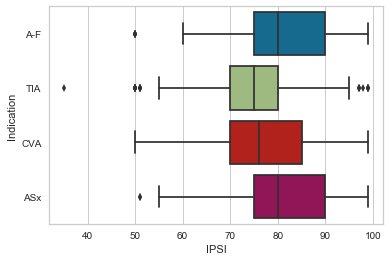

In [33]:
sns.boxplot(x = clean_data["IPSI"], y = clean_data["Indication"])

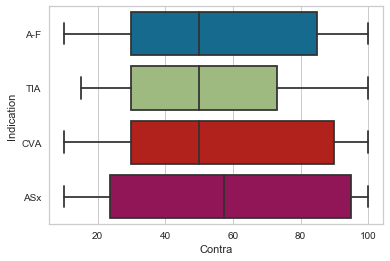

In [34]:
sns.boxplot(x = clean_data["Contra"], y = clean_data["Indication"])

In [35]:
Q1 = clean_data.quantile(0.25)
Q3 = clean_data.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

IPSI      12.0
Contra    55.0
NoRisk     1.0
Risk       1.0
dtype: float64


In [36]:
#ipsi_num = clean_data["IPSI"] - 76
#ipsi_num
#dummies["IPSI"] = dummies["IPSI"] - 39
#corr = dummies[dummies["Diabetes_yes"] == 1].mean()
#sns.heatmap(dummies.corr(), annot=True)
#plt.show()

### Normalise the values

In [37]:
#normalise the IPSI and Contra values so they can be easily evaluated within models
clean_data["IPSI"] = (clean_data["IPSI"] - clean_data["IPSI"].mean()) \
/ (clean_data["IPSI"].max() - clean_data["IPSI"].min())

clean_data["Contra"] = (clean_data["Contra"] - clean_data["Contra"].mean()) \
/ (clean_data["Contra"].max() - clean_data["Contra"].min())

clean_data.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,A-F,no,no,yes,no,no,-0.012938,-0.407422,NoRisk,1,0
1,TIA,no,no,no,no,no,-0.137938,0.037022,NoRisk,1,0
2,A-F,no,yes,yes,no,no,0.252687,-0.185200,Risk,0,1
3,TIA,no,no,yes,no,no,0.174562,0.314800,Risk,0,1
4,CVA,no,no,no,no,no,-0.137938,-0.407422,NoRisk,1,0


## Preprocessing the data

In [38]:
print("Indication' : ",clean_data['Indication'].unique())
print("Diabetes' : ",clean_data['Diabetes'].unique())
print("IHD' : ",clean_data['IHD'].unique())
print("Hypertension' : ",clean_data['Hypertension'].unique())
print("Arrhythmia' : ",clean_data['Arrhythmia'].unique())
print("History' : ",clean_data['History'].unique())
print("label' : ",clean_data['label'].unique())

Indication' :  ['A-F' 'TIA' 'CVA' 'ASx']
Diabetes' :  ['no' 'yes']
IHD' :  ['no' 'yes']
Hypertension' :  ['yes' 'no']
Arrhythmia' :  ['no' 'yes']
History' :  ['no' 'yes']
label' :  ['NoRisk' 'Risk']


In [39]:
#create the variable that the new data will go into, thus maintaining data integrity
clean_data_process = clean_data
# create the Labelencoder object
le = preprocessing.LabelEncoder()
#convert the categorical columns into numeric
clean_data_process['Indication'] = le.fit_transform(clean_data['Indication'])
clean_data_process['Diabetes'] = le.fit_transform(clean_data['Diabetes'])
clean_data_process['IHD'] = le.fit_transform(clean_data['IHD'])
clean_data_process['Hypertension'] = le.fit_transform(clean_data['Hypertension'])
clean_data_process['Arrhythmia'] = le.fit_transform(clean_data['Arrhythmia'])
clean_data_process['History'] = le.fit_transform(clean_data['History'])
clean_data_process['label'] = le.fit_transform(clean_data['label'])
 
#display the initial records
clean_data_process.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra,label,NoRisk,Risk
0,0,0,0,1,0,0,-0.012938,-0.407422,0,1,0
1,3,0,0,0,0,0,-0.137938,0.037022,0,1,0
2,0,0,1,1,0,0,0.252687,-0.185200,1,0,1
3,3,0,0,1,0,0,0.174562,0.314800,1,0,1
4,2,0,0,0,0,0,-0.137938,-0.407422,0,1,0


In [40]:
#removing the risk and no risk columns
riskclassify = [col for col in clean_data_process.columns if col not in ['Risk','NoRisk','label']]
meddata = clean_data_process[riskclassify]
meddata.head()

,Indication,Diabetes,IHD,Hypertension,Arrhythmia,History,IPSI,Contra
0,0,0,0,1,0,0,-0.012938,-0.407422
1,3,0,0,0,0,0,-0.137938,0.037022
2,0,0,1,1,0,0,0.252687,-0.185200
3,3,0,0,1,0,0,0.174562,0.314800
4,2,0,0,0,0,0,-0.137938,-0.407422


### K-Fold Cross-Validation

In [41]:
#kf = KFold(n_splits=10, shuffle=False, random_state=None) 

#for train_index, test_index in kf.split(clean_data_process):
#      print("Train:", train_index, "Validation:",test_index)      

In [42]:
#declare the target of the model
target = clean_data['label']

In [43]:
#create and split up the training and test data for the models
#random state is used so that we get reproducible results every time.
x = meddata
y = target

#create the train and test sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.30, random_state = 0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1050, 8)
(1050,)
(450, 8)
(450,)


### Linear Regression Model

Cross Validation scoring

In [44]:
multireg = LinearRegression()
acc_score_lin = cross_val_score(multireg, x, y, cv = 10)
print(acc_score_lin)
#lin_score = cross_val_score(multireg, x, y, cv = 5)

[0.71796008 0.71492389 0.727394   0.74826501 0.74550334 0.72781924
 0.69135548 0.70202346 0.73519155 0.72138049]


In [45]:
print("Accuracy: %0.2f (+/- %0.2f)" % (acc_score_lin.mean(), acc_score_lin.std() * 2))

Accuracy: 0.72 (+/- 0.03)


This model has a low accuracy score, it will probably not be a worthwhile choice for a final implementation model

In [46]:
#skf = StratifiedKFold(n_splits=5)

#for train, test in skf.split(x,y):
    #print("%s %s" % (train,test))

### Naive Bayes Gaussian Model

The first model that will be created, is the Naive Bayes model. This is a good first choice due to this alrogithm ability to classify an outcome given a certain set of events. The dataset we have has events that lead to the risk or no risk result.

In [47]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#train the algorithm on training data and predict using the testing data
pred = gnb.fit(x_train, y_train).predict(x_test)
#print(pred.tolist())
#print the accuracy score of the model
print("Naive-Bayes accuracy : %0.2f " % accuracy_score(y_test, pred, normalize = True))

Naive-Bayes accuracy : 0.91 


How will the outcome of this model change if we do this with cross validation instead of splitting the train and test sets ourselves?

In [48]:
#create an object of the type GaussianNB
gnb = GaussianNB()
#Train the algorithm
gauss_score = cross_val_score(gnb, x, y, cv= 10, scoring='accuracy')
#print(gauss_score)
print("Naive Bayes Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (gauss_score.mean(), gauss_score.std() * 2))

Naive Bayes Cross-Validation Accuracy : 0.90 (+/- 0.05)


In [49]:
#create a confusion matrix for the dataset through cross validation folds
y_pred = cross_val_predict(gnb, x, y, cv=10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      1000
           1       0.95      0.73      0.83       500

   micro avg       0.90      0.90      0.90      1500
   macro avg       0.92      0.86      0.88      1500
weighted avg       0.90      0.90      0.89      1500

[[981  19]
 [134 366]]


In [50]:
#calculate the mean absolute error 
mean_absolute_error(y,y_pred)

0.102

For the Naive Bayes model, the accuracy when running cross validation tends to be around the same each time, but there is less bias as all of the dataset is used testing than just one defined split..

In [51]:
print(metrics.classification_report(y_test, pred))
cf_nb = confusion_matrix(y_test, pred)
print(cf_nb)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       306
           1       0.97      0.73      0.83       144

   micro avg       0.91      0.91      0.91       450
   macro avg       0.93      0.86      0.88       450
weighted avg       0.91      0.91      0.90       450

[[303   3]
 [ 39 105]]
Mean Absolute Error: 0.09333333333333334
Mean Squared Error: 0.09333333333333334
Root Mean Squared Error: 0.30550504633038933


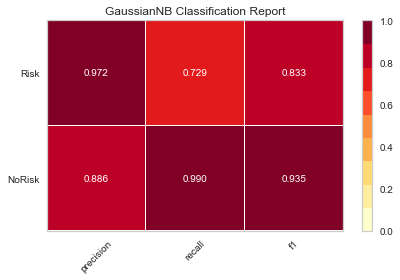

In [52]:
# Instantiate the classification model and visualizer
visualizer = ClassificationReport(gnb, classes=['NoRisk','Risk'])
visualizer.fit(x_train, y_train) # Fit the training data to the visualizer
visualizer.score(x_test, y_test) # Evaluate the model on the test data
g = visualizer.poof() # Draw/show/poof the data

Confusion matrix, without normalization
[[303   3]
 [ 39 105]]
Normalized confusion matrix
[[0.99 0.01]
 [0.27 0.73]]


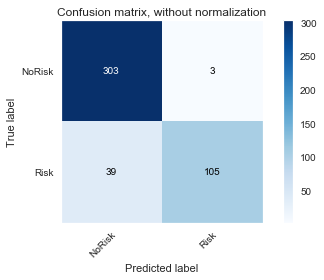

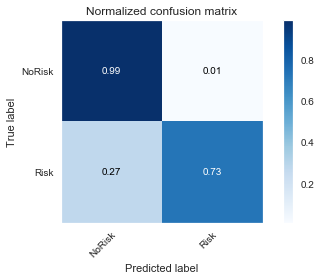

In [53]:
classes = ['NoRisk', 'Risk']
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    sns.set_style("dark")
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cf_nb = confusion_matrix(y_test, pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cf_nb = cf_nb.astype('float') / cf_nb.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cf_nb)

    fig, ax = plt.subplots()
    im = ax.imshow(cf_nb, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cf_nb.shape[1]),
           yticks=np.arange(cf_nb.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cf_nb.max() / 2.
    for i in range(cf_nb.shape[0]):
        for j in range(cf_nb.shape[1]):
            ax.text(j, i, format(cf_nb[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cf_nb[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, pred, classes=classes, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Linear SVC Model

Creating the Linear Support Vector Classification model.

In [54]:
svc_model = LinearSVC(random_state=0)
#train the algorithm on training data and predict using the testing data
pred = svc_model.fit(x_train, y_train).predict(x_test)
#print the accuracy score of the model
print("LinearSVC accuracy : %0.2f " % accuracy_score(y_test, pred, normalize = True))

LinearSVC accuracy : 0.97 


In [55]:
print(metrics.classification_report(y_test, pred))
cf_svc = confusion_matrix(y_test, pred)
print(cf_svc)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       306
           1       0.99      0.93      0.96       144

   micro avg       0.97      0.97      0.97       450
   macro avg       0.98      0.96      0.97       450
weighted avg       0.97      0.97      0.97       450

[[304   2]
 [ 10 134]]
Mean Absolute Error: 0.02666666666666667
Mean Squared Error: 0.02666666666666667
Root Mean Squared Error: 0.16329931618554522


In [56]:
svc_model = LinearSVC(random_state=0)
#Train the algorithm
svcscore = cross_val_score(svc_model, x, y, cv = 10, scoring='accuracy')
print("Linear SVC Cross-Validation Accuracy : %0.2f (+/- %0.2f)" % \
      (svcscore.mean(), svcscore.std() * 2))

Linear SVC Cross-Validation Accuracy : 0.97 (+/- 0.03)


In [57]:
y_pred = cross_val_predict(svc_model, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1000
           1       0.96      0.94      0.95       500

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.96      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[982  18]
 [ 28 472]]


### K-Nearest Neighbours Model - using Cross Validation

In [58]:
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(x_train, y_train)
# predict the response
pred = neigh.predict(x_test)
# evaluate accuracy
print ("KNeighbors accuracy score : %0.2f " % accuracy_score(y_test, pred))

KNeighbors accuracy score : 0.97 


In [59]:
print(metrics.classification_report(y_test, pred))
cf_knn = confusion_matrix(y_test, pred)
print(cf_knn)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98       306
           1       0.96      0.93      0.95       144

   micro avg       0.97      0.97      0.97       450
   macro avg       0.97      0.96      0.96       450
weighted avg       0.97      0.97      0.97       450

[[301   5]
 [ 10 134]]
Mean Absolute Error: 0.03333333333333333
Mean Squared Error: 0.03333333333333333
Root Mean Squared Error: 0.18257418583505536


In [60]:
neigh = KNeighborsClassifier(n_neighbors=5)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
#print(knnscore)
print("KNeighbours Accuracy : %0.2f (+/- %0.2f)" % (knnscore.mean(), knnscore.std() * 2))

KNeighbours Accuracy : 0.97 (+/- 0.03)


In [61]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.96      0.95      0.95       500

   micro avg       0.97      0.97      0.97      1500
   macro avg       0.97      0.96      0.97      1500
weighted avg       0.97      0.97      0.97      1500

[[978  22]
 [ 24 476]]


### Finding the best value for K for the KNN model

In [62]:
#search for an optimal value for K for KNN
k_range = range(1, 31)
k_scores = []
for k in k_range:
    neigh = KNeighborsClassifier(n_neighbors=k)
    knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
    k_scores.append(knnscore.mean())
print(k_scores)

[0.9879999999999999, 0.9846666666666666, 0.9799999999999999, 0.974, 0.9693333333333334, 0.9706666666666666, 0.9646666666666667, 0.9613333333333334, 0.96, 0.9533333333333331, 0.952, 0.9453333333333334, 0.9486666666666667, 0.9473333333333332, 0.95, 0.95, 0.9493333333333334, 0.9506666666666665, 0.9466666666666667, 0.9466666666666667, 0.9473333333333335, 0.9433333333333331, 0.9426666666666668, 0.9380000000000001, 0.9380000000000001, 0.9339999999999999, 0.9339999999999999, 0.9246666666666667, 0.9226666666666669, 0.9200000000000002]


Text(0, 0.5, 'Cross-Validated Accuracy')

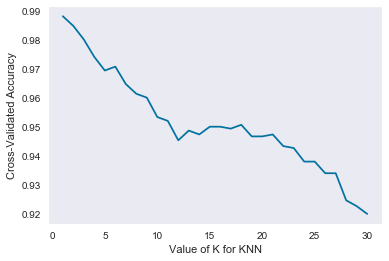

In [63]:
plt.plot(k_range,k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

Re-test with the most optimal k-value to see if the accuracy differs

In [64]:
neigh = KNeighborsClassifier(n_neighbors=3)
#Train the algorithm
knnscore = cross_val_score(neigh, x, y, cv=10, scoring='accuracy')
#print(knnscore)
print("KNeighbours Accuracy : %0.2f (+/- %0.2f)" % (knnscore.mean(), knnscore.std() * 2))

KNeighbours Accuracy : 0.98 (+/- 0.02)


In [65]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.97      0.97      0.97       500

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

[[985  15]
 [ 15 485]]


### Logistic Regression with Cross Validation

In [66]:
logreg =  LogisticRegression(solver='lbfgs', max_iter=1000)
logreg.fit(x_train, y_train)
# predict the response
pred = logreg.predict(x_test)
# evaluate accuracy
print ("Logistic Regression accuracy score : %0.2f " % accuracy_score(y_test, pred))

Logistic Regression accuracy score : 0.95 


In [67]:
print(metrics.classification_report(y_test, pred))
cf_lr = confusion_matrix(y_test, pred)
print(cf_lr)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       306
           1       0.98      0.88      0.92       144

   micro avg       0.95      0.95      0.95       450
   macro avg       0.96      0.93      0.94       450
weighted avg       0.95      0.95      0.95       450

[[303   3]
 [ 18 126]]
Mean Absolute Error: 0.04666666666666667
Mean Squared Error: 0.04666666666666667
Root Mean Squared Error: 0.21602468994692867


In [68]:
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)
logregscore = cross_val_score(logreg, x, y, cv=10, scoring='accuracy')
print("Logistic Regression Accuracy : %0.2f (+/- %0.2f)" % \
      (logregscore.mean(), logregscore.std() * 2))

Logistic Regression Accuracy : 0.96 (+/- 0.03)


In [69]:
y_pred = cross_val_predict(neigh, x, y, cv = 10)
print(metrics.classification_report(y, y_pred))
conf_mat = confusion_matrix(y, y_pred)
print(conf_mat)
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1000
           1       0.97      0.97      0.97       500

   micro avg       0.98      0.98      0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

[[985  15]
 [ 15 485]]
Mean Absolute Error: 0.02
Mean Squared Error: 0.02
Root Mean Squared Error: 0.1414213562373095


### Decision Tree

In [70]:
#Create the decision tree classifier
clf = tree.DecisionTreeClassifier(max_depth=5)
#adjusting max depth increases accuracy, all the way up to depth of 10 = 99% accuracy
#but this is hard to visually understand

#Train the classifier
clf = clf.fit(x_train, y_train)

#Predict what the response will be for the test dataset
pred = clf.predict(x_test)

#Model Accuracy
print ("Decision Tree accuracy score : %0.2f " % accuracy_score(y_test, pred))

Decision Tree accuracy score : 0.97 


The max depth, defines how far in the depth the decision tree wil go, from top to bottom. As expected a higher depth will allow a higher prediction accuracy, but also results in a higher chance of overfitting skewing the result of the model

#### Visualising the Decision Tree

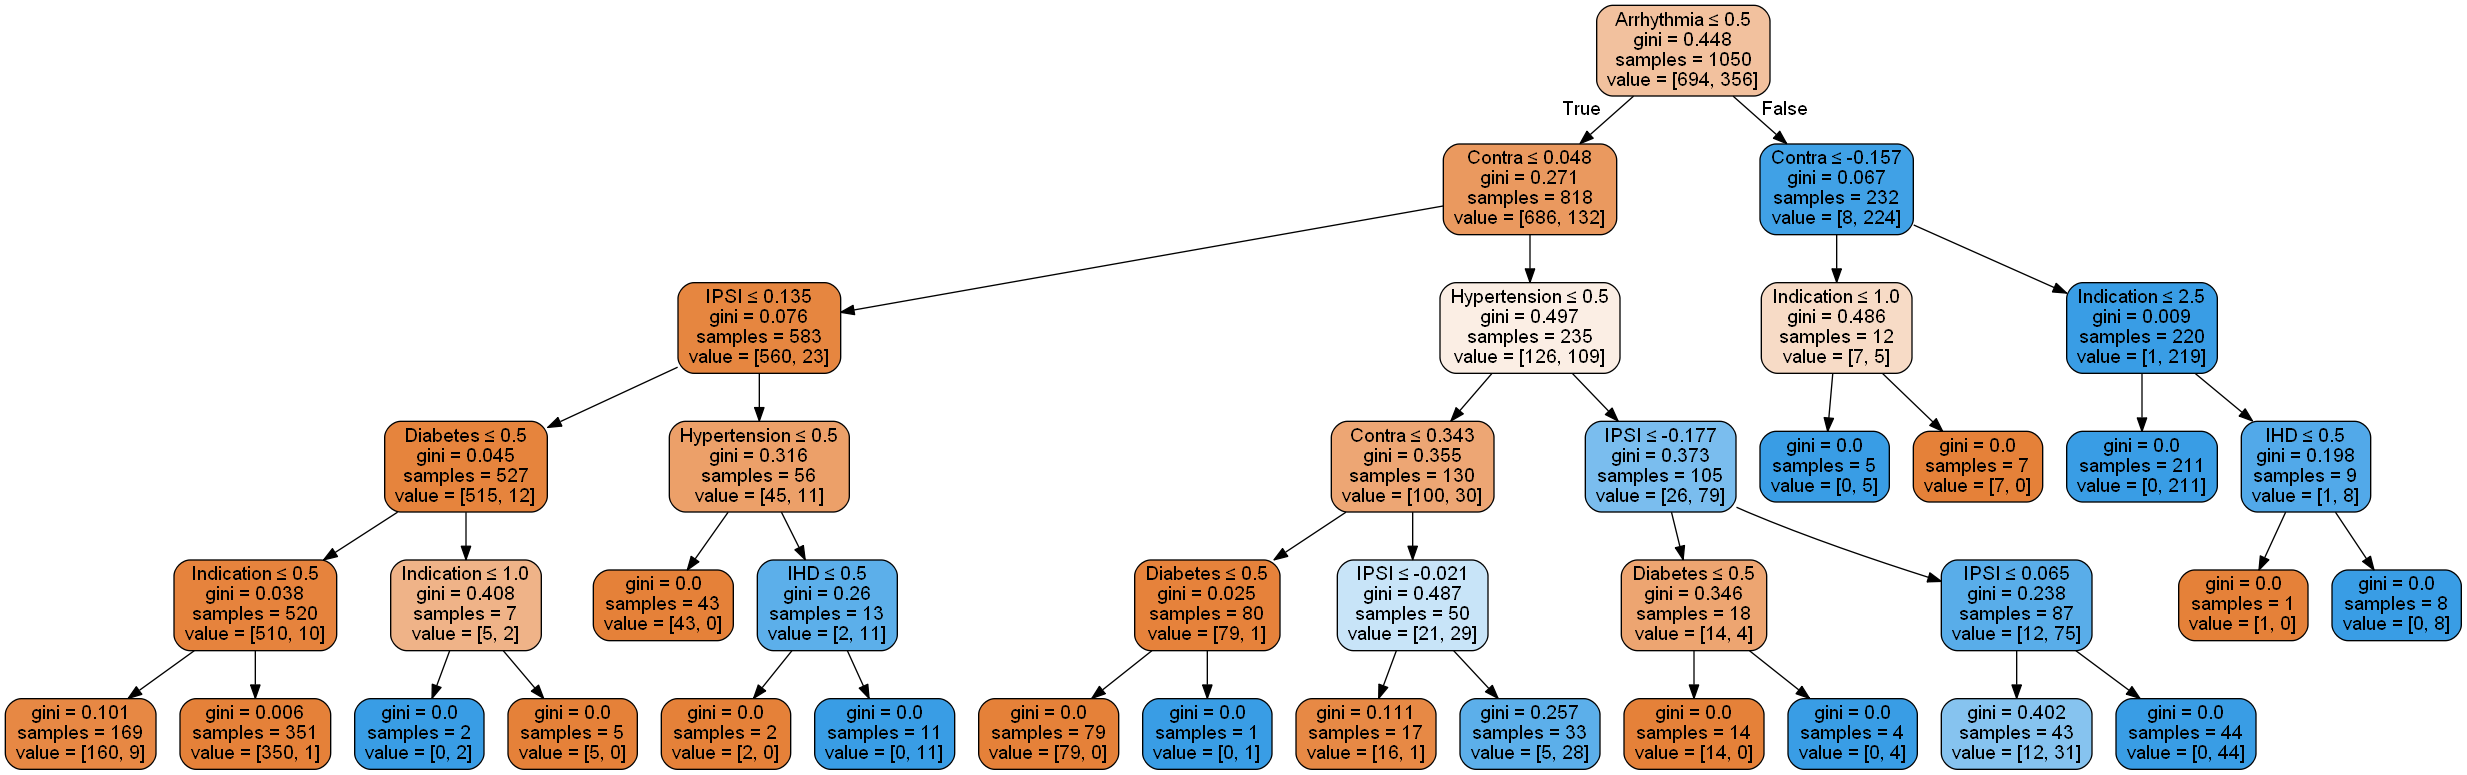

In [71]:
features = list(x.columns)

#The gini score is a metric that quantifies the purity of the node/leaf 
#A gini score greater than zero implies that samples contained within that node belong 
#to different classes. 
#https://towardsdatascience.com/scikit-learn-decision-trees-explained-803f3812290d

tree.export_graphviz(clf, out_file='tree.dot',
               filled=True, 
                     rounded=True,
                     special_characters=True, 
                     feature_names = features)

graph = pydotplus.graph_from_dot_file('tree.dot')
Image(graph.create_png())

In [72]:
print(metrics.classification_report(y_test, pred))
cf_dt = confusion_matrix(y_test, pred)
print(cf_dt)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       306
           1       0.99      0.92      0.96       144

   micro avg       0.97      0.97      0.97       450
   macro avg       0.98      0.96      0.97       450
weighted avg       0.97      0.97      0.97       450

[[305   1]
 [ 11 133]]


not possible to visaulise DT without fitting, which is not possible through CV

In [73]:
clf = tree.DecisionTreeClassifier(max_depth=4)
dtscore = cross_val_score(clf, x, y, cv=10, scoring='accuracy')
print("Decision Tree Accuracy : %0.2f (+/- %0.2f)" % \
      (dtscore.mean(), dtscore.std() * 2))

Decision Tree Accuracy : 0.94 (+/- 0.03)


In [74]:
regressor = DecisionTreeRegressor()
regressor.fit(x_train, y_train)

y_pred = regressor.predict(x_test)

df=pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df.head(10)

,Actual,Predicted
477,0,0.0
9,1,1.0
1519,0,0.0
54,0,0.0
1431,1,1.0
1176,0,0.0
747,1,0.0
175,0,0.0
261,0,0.0
1437,0,0.0


In [75]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.013333333333333334
Mean Squared Error: 0.013333333333333334
Root Mean Squared Error: 0.11547005383792516
